# Nereus Diagnostics Demonstration

This notebook demonstrates the diagnostic functions in the `nereus` package for computing oceanographic metrics.

## Features covered:
- **Sea Ice Diagnostics**: ice_area, ice_volume, ice_extent
- **Ocean Diagnostics**: volume_mean, heat_content
- **Hovmoller Diagrams**: time-depth and time-latitude plots

## Setup and Data Loading

In [1]:
import nereus as nr
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

print(f"Nereus version: {nr.__version__}")

Nereus version: 0.2.0


In [2]:
# Load FESOM2 mesh and data
mesh = xr.open_dataset('/Users/nkolduno/PYTHON/DATA/nereus_tutorial_data/fesom.mesh.diag.nc')
data = xr.open_mfdataset('/Users/nkolduno/PYTHON/DATA/nereus_tutorial_data/temp.fesom.196*.nc')
data_u = xr.open_mfdataset('/Users/nkolduno/PYTHON/DATA/nereus_tutorial_data/u.fesom.196*.nc')
data_conc = xr.open_mfdataset('/Users/nkolduno/PYTHON/DATA/nereus_tutorial_data/a_ice.fesom.196*.nc')
data_thick = xr.open_mfdataset('/Users/nkolduno/PYTHON/DATA/nereus_tutorial_data/m_ice.fesom.196*.nc')

print(f"Mesh nodes: {len(mesh.lon)}")
print(f"Temperature shape: {data.temp.shape}")
print(f"Ice concentration shape: {data_conc.a_ice.shape}")
print(f"Ice thickness shape: {data_thick.m_ice.shape}")

Mesh nodes: 126858
Temperature shape: (120, 47, 126858)
Ice concentration shape: (120, 126858)
Ice thickness shape: (120, 126858)


In [3]:
# Explore mesh variables
print("Mesh variables:")
for var in mesh.data_vars:
    print(f"  {var}: {mesh[var].dims} - shape {mesh[var].shape}")

Mesh variables:
  fesom_mesh: () - shape ()
  elem_area: ('elem',) - shape (244659,)
  nlevels_nod2D: ('nod2',) - shape (126858,)
  nlevels: ('elem',) - shape (244659,)
  nod_in_elem2D_num: ('nod2',) - shape (126858,)
  nod_part: ('nod2',) - shape (126858,)
  elem_part: ('elem',) - shape (244659,)
  zbar_e_bottom: ('elem',) - shape (244659,)
  zbar_n_bottom: ('nod2',) - shape (126858,)
  lon: ('nod2',) - shape (126858,)
  lat: ('nod2',) - shape (126858,)
  nod_area: ('nz', 'nod2') - shape (48, 126858)
  face_nodes: ('n3', 'elem') - shape (3, 244659)
  edge_nodes: ('n2', 'edg_n') - shape (2, 371644)
  face_edges: ('n3', 'elem') - shape (3, 244659)
  face_links: ('n3', 'elem') - shape (3, 244659)
  edge_face_links: ('n2', 'edg_n') - shape (2, 371644)
  nod_in_elem2D: ('N', 'nod2') - shape (9, 126858)
  edge_cross_dxdy: ('n4', 'edg_n') - shape (4, 371644)
  gradient_sca_x: ('n3', 'elem') - shape (3, 244659)
  gradient_sca_y: ('n3', 'elem') - shape (3, 244659)
  gradient_vec_x: ('n3', 'ele

In [6]:
# Extract key mesh variables
lon = mesh.lon.values
lat = mesh.lat.values
area = mesh.nod_area.values  # Cell area in m^2
area_surface = area[0,:]
depth = data.nz1.values
# Compute layer thicknesses from depth levels
layer_thickness = np.diff(mesh.nz.values)

print(f"Coordinates: lon {lon.shape}, lat {lat.shape}")
print(f"Cell areas: {area.shape}, total area = {area.sum()/1e12:.2f} million km²")
print(f"Depth levels: {len(depth)} levels from {depth[0]:.1f}m to {depth[-1]:.1f}m")

Coordinates: lon (126858,), lat (126858,)
Cell areas: (48, 126858), total area = 12978.15 million km²
Depth levels: 47 levels from 2.5m to 6125.0m


---
## 1. Sea Ice Diagnostics

Nereus provides three sea ice diagnostic functions:
- `nr.ice_area()` - Total sea ice area (concentration-weighted)
- `nr.ice_volume()` - Total sea ice volume
- `nr.ice_extent()` - Sea ice extent (area above concentration threshold)

### 1.1 Explore Ice Data

In [5]:
# Ice concentration (a_ice) - fraction from 0 to 1
sic = data_conc.a_ice  # Sea ice concentration
sit = data_thick.m_ice  # Sea ice thickness

print(f"Ice concentration: {sic.dims}")
print(f"Ice thickness: {sit.dims}")

# Check value ranges
print(f"\nConcentration range: {float(sic.min()):.3f} to {float(sic.max()):.3f}")
print(f"Thickness range: {float(sit.min()):.3f} to {float(sit.max()):.3f} m")

Ice concentration: ('time', 'nod2')
Ice thickness: ('time', 'nod2')

Concentration range: 0.000 to 1.000
Thickness range: 0.000 to 9.101 m


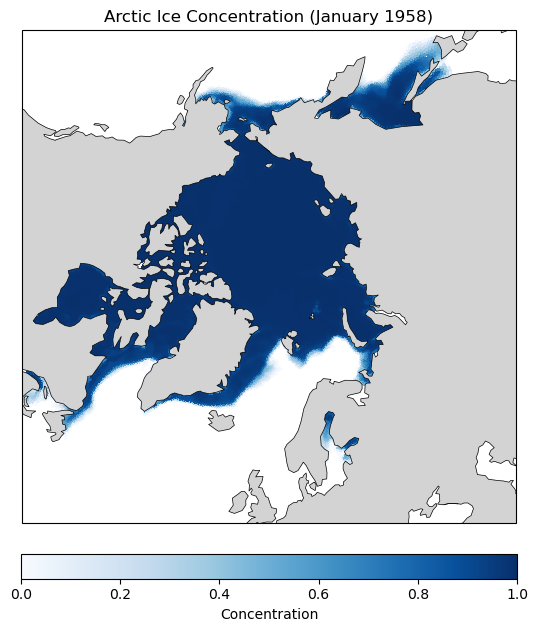

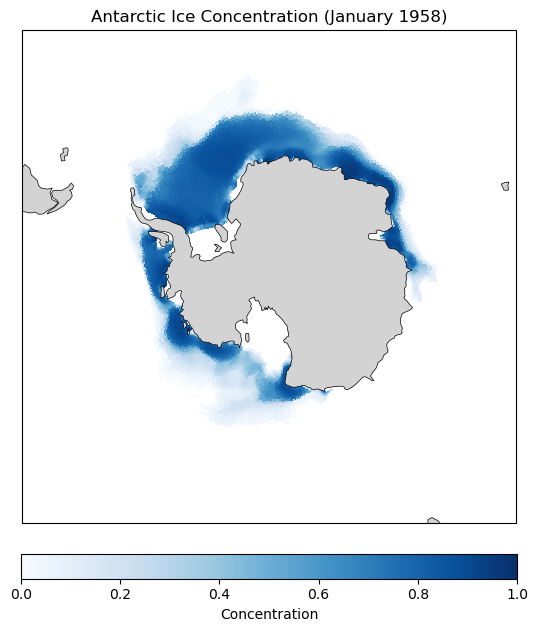

In [7]:
# Visualize ice concentration for January
sic_jan = sic.isel(time=0)

# Northern Hemisphere
fig, ax1, _ = nr.plot(
    sic_jan, lon, lat,
    projection="np",
    extent=(-180, 180, 50, 90),
    title="Arctic Ice Concentration (January 1958)",
    colorbar_label="Concentration",
    cmap="Blues",
    vmin=0, vmax=1,
    resolution=0.1,
    influence_radius=30000,
    land=True
)

# Southern Hemisphere
fig, ax2, _ = nr.plot(
    sic_jan, lon, lat,
    projection="sp",
    extent=(-180, 180, -90, -50),
    title="Antarctic Ice Concentration (January 1958)",
    colorbar_label="Concentration",
    cmap="Blues",
    vmin=0, vmax=1,
    resolution=0.1,
    influence_radius=50000,
    land=True
)

### 1.2 Ice Area

Sea ice area is computed as the sum of cell areas weighted by ice concentration:

$$\text{Ice Area} = \sum_i A_i \times C_i$$

where $A_i$ is the cell area and $C_i$ is the ice concentration.

In [10]:
# Compute ice area by hemisphere using masks
nh_mask = lat > 0  # Northern Hemisphere
sh_mask = lat < 0  # Southern Hemisphere

ice_area_nh = nr.ice_area(sic, area_surface, mask=nh_mask).compute()
ice_area_sh = nr.ice_area(sic, area_surface, mask=sh_mask).compute()

print(f"\nNorthern Hemisphere:")
print(f"  Maximum (March): {ice_area_nh.max()/1e12:.2f} million km²")
print(f"  Minimum (September): {ice_area_nh.min()/1e12:.2f} million km²")

print(f"\nSouthern Hemisphere:")
print(f"  Maximum (September): {ice_area_sh.max()/1e12:.2f} million km²")
print(f"  Minimum (February): {ice_area_sh.min()/1e12:.2f} million km²")


Northern Hemisphere:
  Maximum (March): 17.04 million km²
  Minimum (September): 6.75 million km²

Southern Hemisphere:
  Maximum (September): 19.02 million km²
  Minimum (February): 0.94 million km²


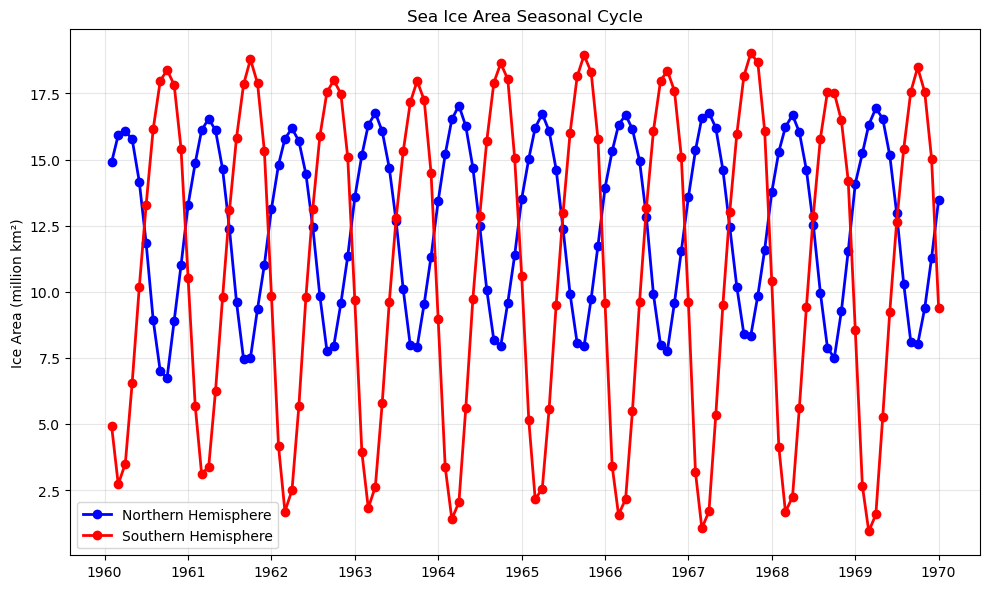

In [11]:

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(sic.time, ice_area_nh / 1e12, 'b-o', label='Northern Hemisphere', linewidth=2)
ax.plot(sic.time, ice_area_sh / 1e12, 'r-o', label='Southern Hemisphere', linewidth=2)
ax.set_ylabel('Ice Area (million km²)')
ax.set_title('Sea Ice Area Seasonal Cycle')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()

### 1.3 Ice Extent

Sea ice extent is the total area of grid cells where ice concentration exceeds a threshold (typically 15%):

$$\text{Ice Extent} = \sum_i A_i \quad \text{where } C_i \geq 0.15$$

In [13]:
# Compute ice extent (default threshold 15%)
ice_extent_nh = nr.ice_extent(sic, area_surface, mask=nh_mask).compute()
ice_extent_sh = nr.ice_extent(sic, area_surface, mask=sh_mask).compute()

print(f"Arctic ice extent (March): {ice_extent_nh[2]/1e12:.2f} million km²")
print(f"Arctic ice extent (September): {ice_extent_nh[8]/1e12:.2f} million km²")
print(f"Antarctic ice extent (September): {ice_extent_sh[8]/1e12:.2f} million km²")
print(f"Antarctic ice extent (February): {ice_extent_sh[1]/1e12:.2f} million km²")

Arctic ice extent (March): 17.06 million km²
Arctic ice extent (September): 8.25 million km²
Antarctic ice extent (September): 20.35 million km²
Antarctic ice extent (February): 4.29 million km²


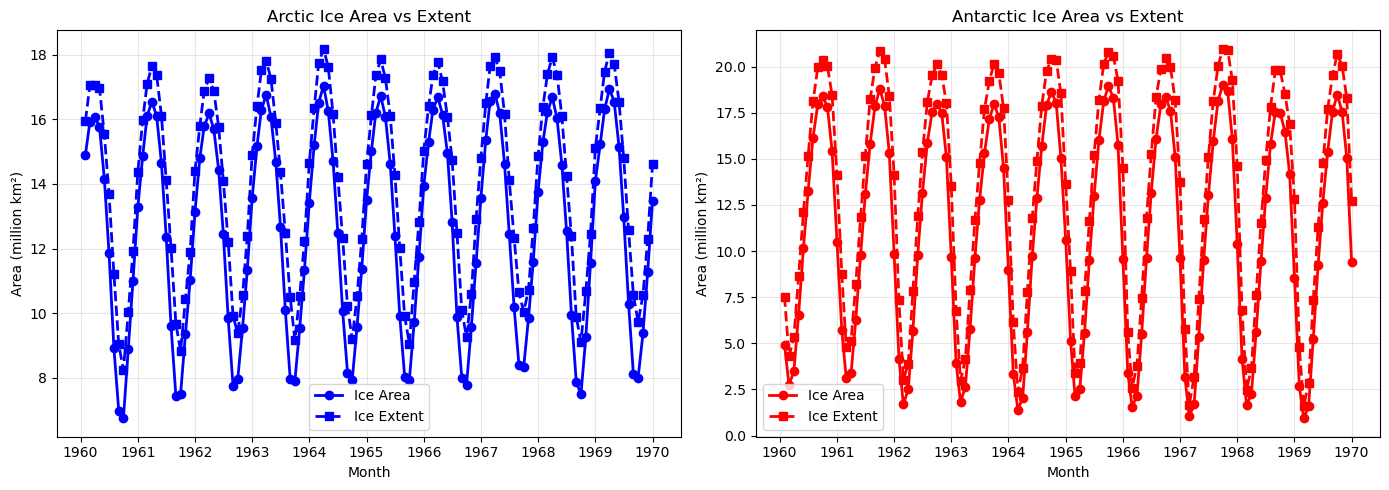

In [14]:
# Compare ice area vs ice extent
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Northern Hemisphere
axes[0].plot(sic.time, ice_area_nh / 1e12, 'b-o', label='Ice Area', linewidth=2)
axes[0].plot(sic.time, ice_extent_nh / 1e12, 'b--s', label='Ice Extent', linewidth=2)
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Area (million km²)')
axes[0].set_title('Arctic Ice Area vs Extent')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Southern Hemisphere
axes[1].plot(sic.time, ice_area_sh / 1e12, 'r-o', label='Ice Area', linewidth=2)
axes[1].plot(sic.time, ice_extent_sh / 1e12, 'r--s', label='Ice Extent', linewidth=2)
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Area (million km²)')
axes[1].set_title('Antarctic Ice Area vs Extent')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()

### 1.4 Ice Volume

Sea-ice volume is computed by summing thickness times grid-cell area, optionally weighted by concentration:

* **Effective thickness** (grid-cell mean; `concentration=None`):
  $$
  V=\sum_i h_{\text{eff},i},A_i
  $$

* **Real thickness** (ice-area mean; provide `concentration`):
  $$
  V=\sum_i h_{\text{ice},i},C_i,A_i
  $$

where (h) is thickness (m), (A) cell area (m(^2)), and (C) concentration (0–1). A mask may be applied to include only selected cells.


In [19]:
# FESOM data use effective sea ice thickness
ice_vol_nh = nr.ice_volume(sit, area_surface, mask=nh_mask).compute()
ice_vol_sh = nr.ice_volume(sit, area_surface, mask=sh_mask).compute()

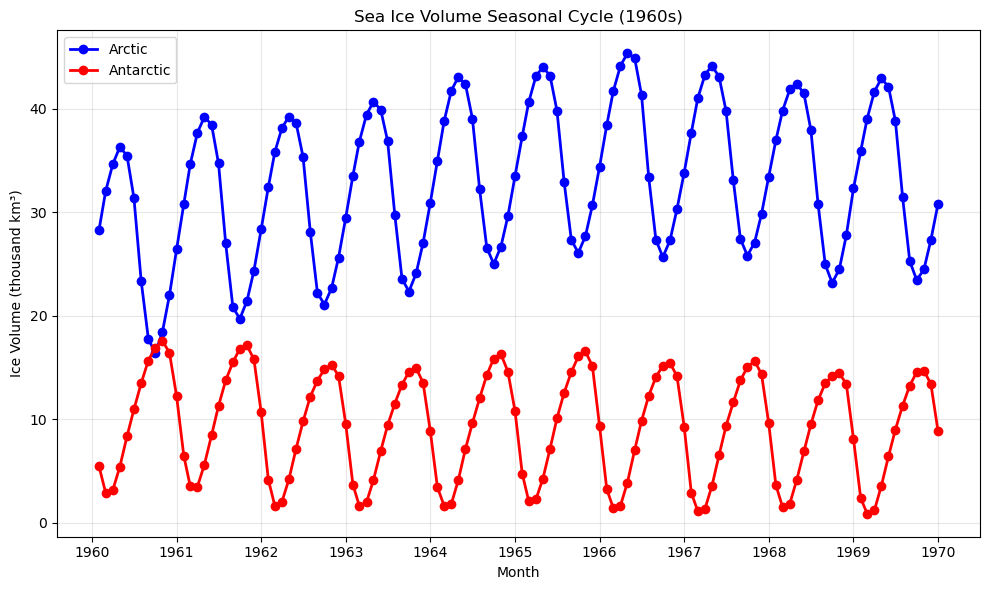

In [21]:
# Plot ice volume seasonal cycle
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(sic.time, ice_vol_nh / 1e12, 'b-o', label='Arctic', linewidth=2)
ax.plot(sic.time, ice_vol_sh / 1e12, 'r-o', label='Antarctic', linewidth=2)
ax.set_xlabel('Month')
ax.set_ylabel('Ice Volume (thousand km³)')
ax.set_title('Sea Ice Volume Seasonal Cycle (1960s)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()

---
## 2. Ocean Diagnostics

Nereus provides ocean diagnostic functions:
- `nr.volume_mean()` - Volume-weighted mean of a quantity
- `nr.heat_content()` - Ocean heat content calculation

### 2.1 Explore 3D Temperature Data

In [ ]:
# Temperature data structure
print(f"Temperature dimensions: {data.temp.dims}")
print(f"Temperature shape: {data.temp.shape}")
print(f"Depth levels: {len(depth)}")
print(f"\nFirst 10 depth levels (m): {depth[:10]}")

### 2.2 Volume-Weighted Mean

The volume-weighted mean accounts for varying cell volumes:

$$\bar{T} = \frac{\sum_{i,k} T_{i,k} \times A_i \times \Delta z_k}{\sum_{i,k} A_i \times \Delta z_k}$$

In [37]:
# Full-depth mean, one time step
mean_temp_full = nr.volume_mean(data['temp'][0,:], area, layer_thickness).compute()
print(f"Global mean temperature (full depth): {mean_temp_full:.2f}°C")

Global mean temperature (full depth): 3.63°C


/var/folders/qn/8rbp_kf17zqff6lpvc8t171mw6t48m/T/ipykernel_15371/2832022027.py:2: UserWarning: area has one more vertical level than data; using the first 47 levels of area to match data (levels vs layers).
  mean_temp_full = nr.volume_mean(data['temp'][0,:], area, layer_thickness).compute()


In [38]:
mean_temp_time_series = nr.volume_mean(data['temp'][:,:], area, layer_thickness).compute()

/var/folders/qn/8rbp_kf17zqff6lpvc8t171mw6t48m/T/ipykernel_15371/2569497230.py:1: UserWarning: area has one more vertical level than data; using the first 47 levels of area to match data (levels vs layers).
  mean_temp_time_series = nr.volume_mean(data['temp'][:,:], area, layer_thickness).compute()


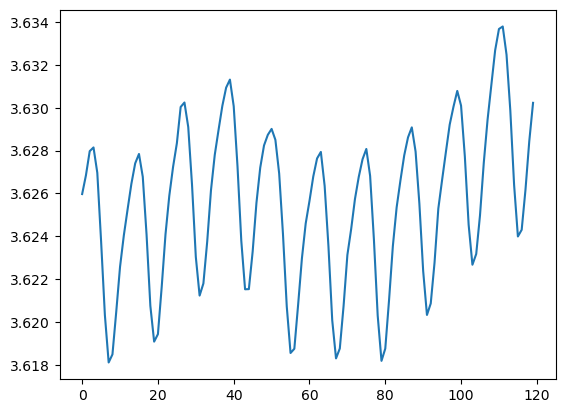

In [40]:
plt.plot(mean_temp_time_series)

In [42]:
%%time
# Mean temperature at different ranges
mean_temp_surface = nr.volume_mean(data['temp'][:,:], area, layer_thickness, depth, depth_max=100).compute()
mean_temp_700 = nr.volume_mean(data['temp'][:,:], area, layer_thickness, depth, depth_max=700).compute()
mean_temp_deep = nr.volume_mean(data['temp'][:,:], area, layer_thickness, depth, depth_min=2000).compute()

<timed exec>:1: UserWarning: area has one more vertical level than data; using the first 47 levels of area to match data (levels vs layers).
<timed exec>:2: UserWarning: area has one more vertical level than data; using the first 47 levels of area to match data (levels vs layers).
<timed exec>:3: UserWarning: area has one more vertical level than data; using the first 47 levels of area to match data (levels vs layers).


CPU times: user 29.9 s, sys: 1.96 s, total: 31.9 s
Wall time: 24.9 s


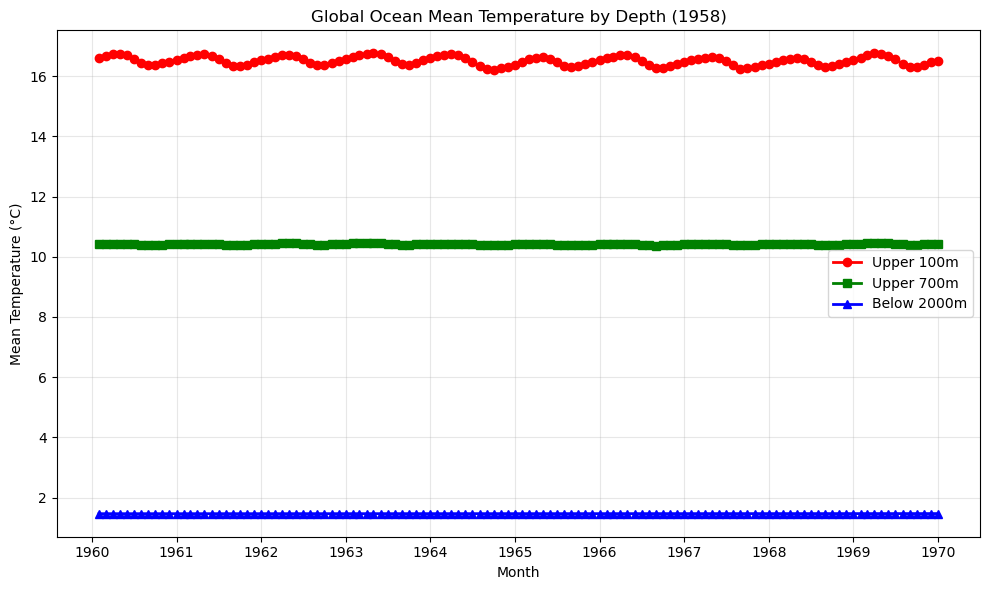

In [43]:
# Plot seasonal cycle of mean temperature
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(data.time, mean_temp_surface, 'r-o', label='Upper 100m', linewidth=2)
ax.plot(data.time, mean_temp_700, 'g-s', label='Upper 700m', linewidth=2)
ax.plot(data.time, mean_temp_deep, 'b-^', label='Below 2000m', linewidth=2)

ax.set_xlabel('Month')
ax.set_ylabel('Mean Temperature (°C)')
ax.set_title('Global Ocean Mean Temperature by Depth (1958)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()

In [51]:
%%time
# Regional mean temperature (e.g., North Atlantic)
natl_mask = (lat > 20) & (lat < 70) & (lon > -80) & (lon < 0)

mean_temp_natl = nr.volume_mean(
    data['temp'], area, layer_thickness, depth,
    depth_max=700, mask=natl_mask
).compute()

# Southern Ocean
so_mask = lat < -60
mean_temp_so = nr.volume_mean(
    data['temp'], area, layer_thickness, depth,
    depth_max=700, mask=so_mask
).compute()

<timed exec>:4: UserWarning: area has one more vertical level than data; using the first 47 levels of area to match data (levels vs layers).
<timed exec>:11: UserWarning: area has one more vertical level than data; using the first 47 levels of area to match data (levels vs layers).


CPU times: user 20.1 s, sys: 1.26 s, total: 21.3 s
Wall time: 16.7 s


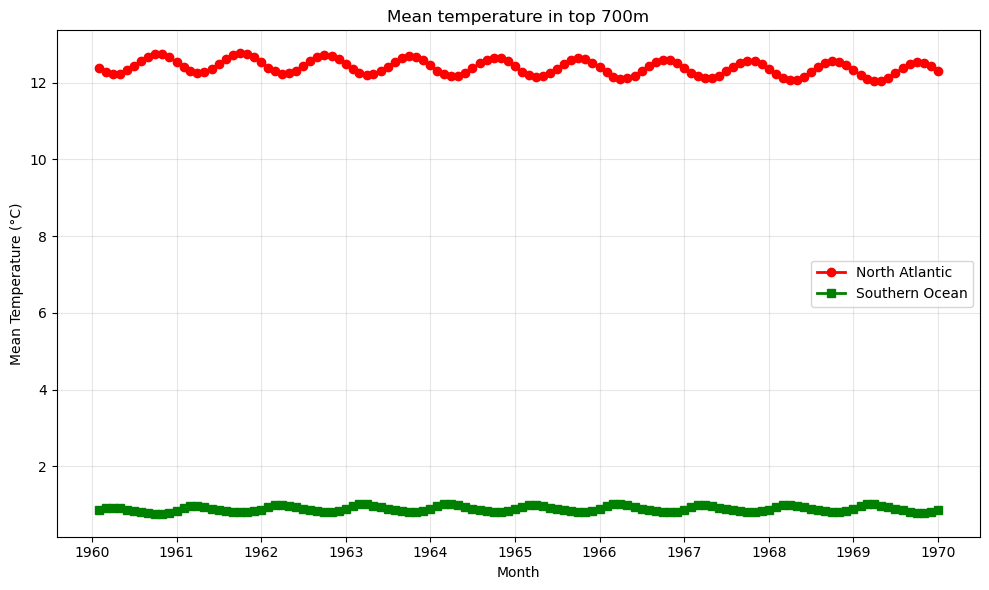

In [53]:
# Plot seasonal cycle of mean temperature
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(data.time, mean_temp_natl, 'r-o', label='North Atlantic', linewidth=2)
ax.plot(data.time, mean_temp_so, 'g-s', label='Southern Ocean', linewidth=2)

ax.set_xlabel('Month')
ax.set_ylabel('Mean Temperature (°C)')
ax.set_title('Mean temperature in top 700m')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()

### 2.3 Ocean Heat Content

Ocean heat content (OHC) is computed from the temperature anomaly relative to a reference temperature:

$$
\Delta T = T - T_{\text{ref}}
$$

Two outputs are supported:

* **Total heat content** (`output="total"`, Joules):
$$  \text{OHC} = \rho,c_p \sum_{i,k} \Delta T_{k,i}; \Delta z_{k,i}; A_{k,i}
  $$
  where (A) can be **surface area** ($A_i$) (1D, used for all depths) or **depth-dependent area** ($A_{k,i}$) (2D).

* **Heat content map** (`output="map"`, $J/m^2$):


  $$
  \text{OHC}*{\text{map}}(i)= \rho,c_p \sum_k \Delta T*{k,i}; \Delta z_{k,i}
  $$
  (area is not used; optional horizontal mask still applies).

Optional `depth_min/depth_max` restrict the vertical sum using the provided layer-center `depth`, and `mask` selects horizontal points. NaNs in temperature are ignored (treated as missing).


In [8]:
# Compute ocean heat content for January
ohc_full = nr.heat_content( data['temp'][0,:,:], area, layer_thickness).compute()
print(f"Total OHC (full depth): {ohc_full:.3e} J")

Total OHC (full depth): 1.960e+25 J


/var/folders/qn/8rbp_kf17zqff6lpvc8t171mw6t48m/T/ipykernel_77338/3280281122.py:2: UserWarning: area has one more vertical level than data; using the first 47 levels of area to match data (levels vs layers).
  ohc_full = nr.heat_content( data['temp'][0,:,:], area, layer_thickness).compute()


In [9]:
ohc_full_map = nr.heat_content( data['temp'][0,:,:], area, layer_thickness, output="map").compute()

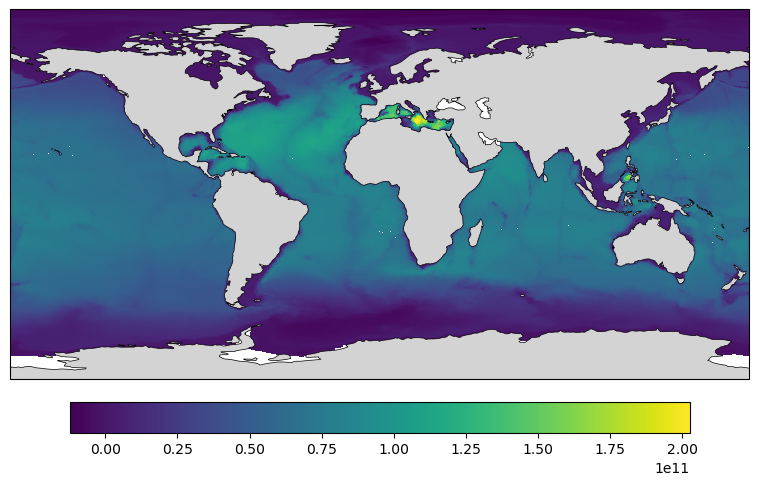

In [13]:
nr.plot(ohc_full_map, lon, lat, land=True, resolution=0.25);

In [16]:
%%time
# Monthly OHC time series
ohc_700_series = nr.heat_content(
        data["temp"], area, layer_thickness, depth, depth_max=700
    ).compute()
ohc_full_series = nr.heat_content(
        data["temp"], area, layer_thickness
    ).compute()


<timed exec>:2: UserWarning: area has one more vertical level than data; using the first 47 levels of area to match data (levels vs layers).
<timed exec>:5: UserWarning: area has one more vertical level than data; using the first 47 levels of area to match data (levels vs layers).


CPU times: user 19.9 s, sys: 1.34 s, total: 21.3 s
Wall time: 16.4 s


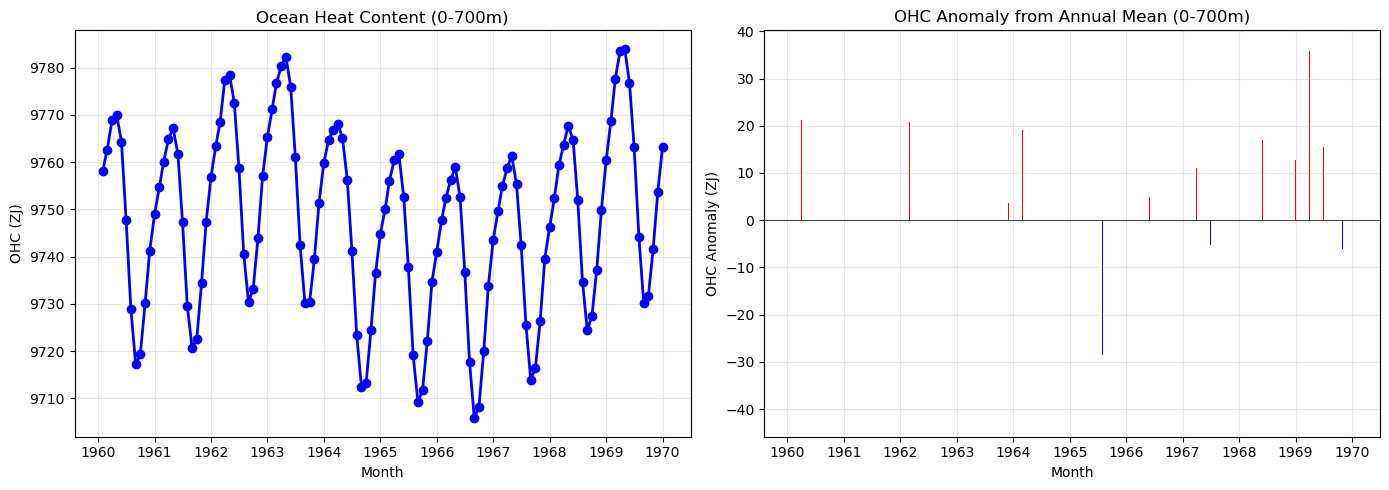

In [17]:
# Plot OHC seasonal cycle
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Absolute values
axes[0].plot(data.time, ohc_700_series / 1e21, 'b-o', label='0-700m', linewidth=2)
axes[0].set_xlabel('Month')
axes[0].set_ylabel('OHC (ZJ)')
axes[0].set_title('Ocean Heat Content (0-700m)')
axes[0].grid(True, alpha=0.3)

# Anomaly from annual mean
ohc_700_anom = ohc_700_series - ohc_700_series.mean()
axes[1].bar(data.time, ohc_700_anom / 1e21, color=['blue' if x < 0 else 'red' for x in ohc_700_anom])
axes[1].axhline(0, color='k', linewidth=0.5)
axes[1].set_xlabel('Month')
axes[1].set_ylabel('OHC Anomaly (ZJ)')
axes[1].set_title('OHC Anomaly from Annual Mean (0-700m)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()

In [19]:
# Effect of reference temperature
print("OHC with different reference temperatures:")
for t_ref in [0, 4, 10]:
    ohc = nr.heat_content(data['temp'][0,:,:], area, layer_thickness, depth, 
                         depth_max=700, reference_temp=t_ref).compute()
    print(f"  T_ref = {t_ref}°C: {ohc/1e21:.1f} ZJ")

OHC with different reference temperatures:
  T_ref = 0°C: 9758.2 ZJ
  T_ref = 4°C: 6014.4 ZJ


/var/folders/qn/8rbp_kf17zqff6lpvc8t171mw6t48m/T/ipykernel_77338/3550152350.py:4: UserWarning: area has one more vertical level than data; using the first 47 levels of area to match data (levels vs layers).
  ohc = nr.heat_content(data['temp'][0,:,:], area, layer_thickness, depth,
/var/folders/qn/8rbp_kf17zqff6lpvc8t171mw6t48m/T/ipykernel_77338/3550152350.py:4: UserWarning: area has one more vertical level than data; using the first 47 levels of area to match data (levels vs layers).
  ohc = nr.heat_content(data['temp'][0,:,:], area, layer_thickness, depth,
/var/folders/qn/8rbp_kf17zqff6lpvc8t171mw6t48m/T/ipykernel_77338/3550152350.py:4: UserWarning: area has one more vertical level than data; using the first 47 levels of area to match data (levels vs layers).
  ohc = nr.heat_content(data['temp'][0,:,:], area, layer_thickness, depth,


  T_ref = 10°C: 398.7 ZJ


---
## 3. Hovmoller Diagrams

Hovmoller diagrams show the evolution of a quantity over time along one spatial dimension (depth or latitude).

- `nr.hovmoller()` - Compute Hovmoller data
- `nr.plot_hovmoller()` - Plot Hovmoller diagrams

### 3.1 Time-Depth Hovmoller

Shows how a quantity varies with depth over time (area-weighted mean at each depth level).

In [22]:
# Get full year of temperature data


# Compute time-depth Hovmoller (global mean)
t_out, z_out, hov_data = nr.hovmoller(
    data['temp'], area,
    time=data.time,
    depth=depth,
    mode="depth"
)

print(f"Hovmoller output shape: {hov_data.shape}")

Hovmoller output shape: (120, 47)


/var/folders/qn/8rbp_kf17zqff6lpvc8t171mw6t48m/T/ipykernel_77338/2117005174.py:5: UserWarning: area has one more vertical level than data; using the first 47 levels of area to match data (levels vs layers).
  t_out, z_out, hov_data = nr.hovmoller(


/Users/nkolduno/micromamba/envs/nereus/lib/python3.11/site-packages/dask/_task_spec.py:768: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)


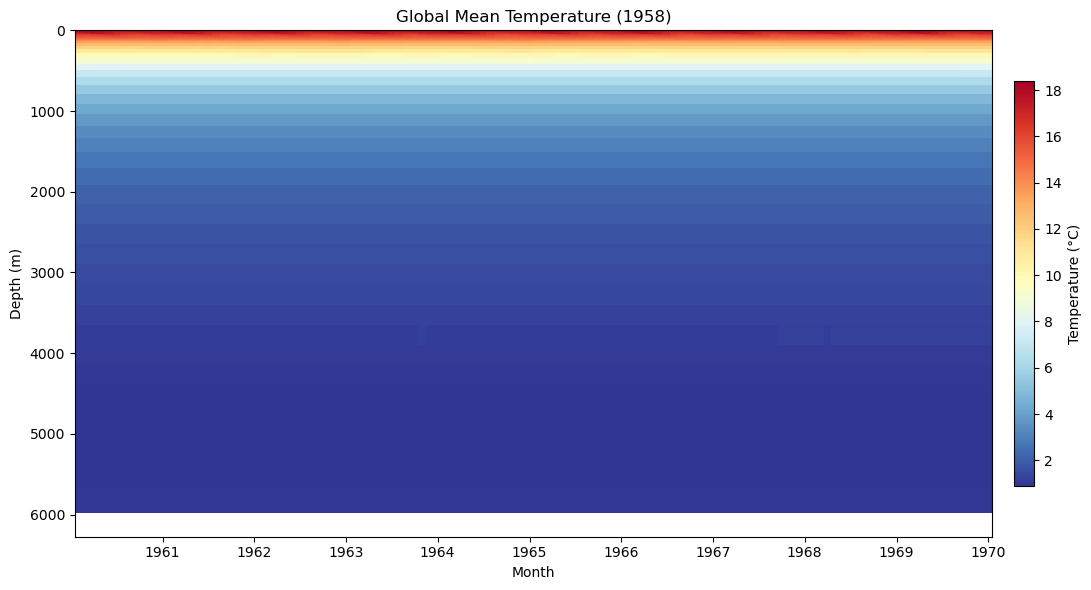

In [23]:
# Plot time-depth Hovmoller
fig, ax = nr.plot_hovmoller(
    t_out, z_out, hov_data,
    mode="depth",
    cmap="RdYlBu_r",
    colorbar_label="Temperature (°C)",
    title="Global Mean Temperature (1958)",
    figsize=(12, 6)
)

ax.set_xlabel("Month")
plt.tight_layout()

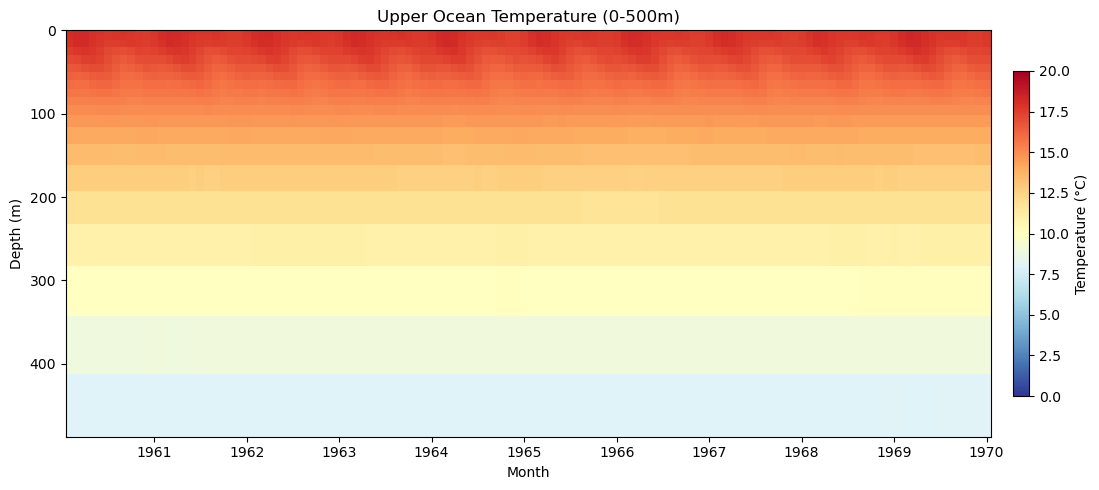

In [24]:
# Zoom in on upper ocean (0-500m)
upper_mask = depth <= 500
depth_upper = depth[upper_mask]
temp_upper = data['temp'][:, upper_mask, :]
area_upper = area[:-1][upper_mask]

t_out, z_out, hov_upper = nr.hovmoller(
    temp_upper, area_upper,
    time=data.time,
    depth=depth_upper,
    mode="depth"
)

fig, ax = nr.plot_hovmoller(
    t_out, z_out, hov_upper,
    mode="depth",
    cmap="RdYlBu_r",
    vmin=0, vmax=20,
    colorbar_label="Temperature (°C)",
    title="Upper Ocean Temperature (0-500m)",
    figsize=(12, 5)
)

ax.set_xlabel("Month")
plt.tight_layout()

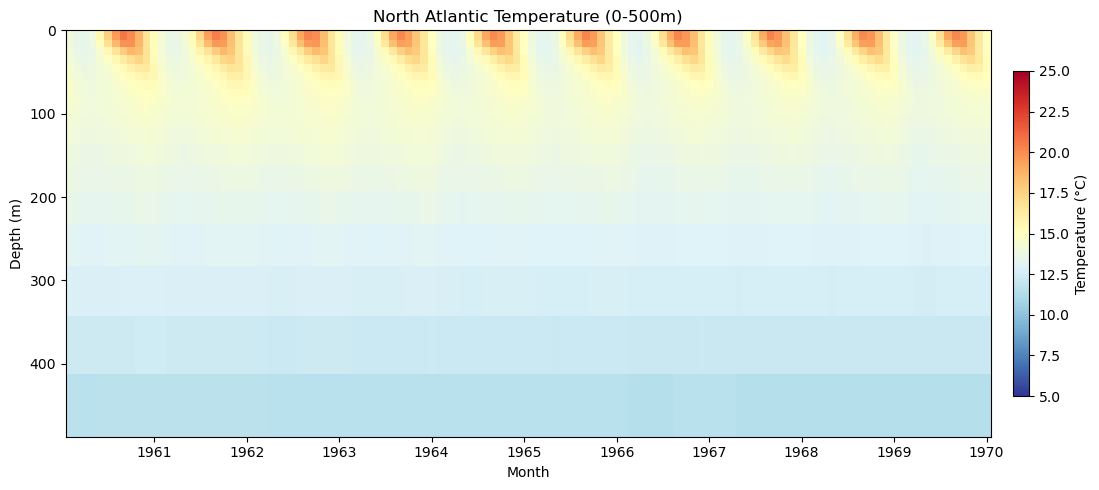

In [25]:
# Regional Hovmoller (North Atlantic)
natl_mask = (lat > 20) & (lat < 70) & (lon > -80) & (lon < 0)

t_out, z_out, hov_natl = nr.hovmoller(
    temp_upper, area_upper,
    time=data.time,
    depth=depth_upper,
    mode="depth",
    mask=natl_mask
)

fig, ax = nr.plot_hovmoller(
    t_out, z_out, hov_natl,
    mode="depth",
    cmap="RdYlBu_r",
    vmin=5, vmax=25,
    colorbar_label="Temperature (°C)",
    title="North Atlantic Temperature (0-500m)",
    figsize=(12, 5)
)

ax.set_xlabel("Month")
plt.tight_layout()

### 3.2 Time-Latitude Hovmoller

Shows how surface quantities vary with latitude over time (zonal and depth mean).

In [26]:
# Get SST data (surface temperature)
sst_all = data.temp.isel(nz1=0)  # Shape: (time, npoints)

print(f"SST data shape: {sst_all.shape}")

# Compute time-latitude Hovmoller
t_out, lat_out, hov_lat = nr.hovmoller(
    sst_all, area,
    time=data.time,
    lat=lat,
    mode="latitude",
    lat_bins=np.arange(-90, 95, 5)  # 5-degree latitude bins
)

print(f"Latitude bins: {len(lat_out)}")
print(f"Hovmoller output shape: {hov_lat.shape}")

SST data shape: (120, 126858)
Latitude bins: 36
Hovmoller output shape: (120, 36)


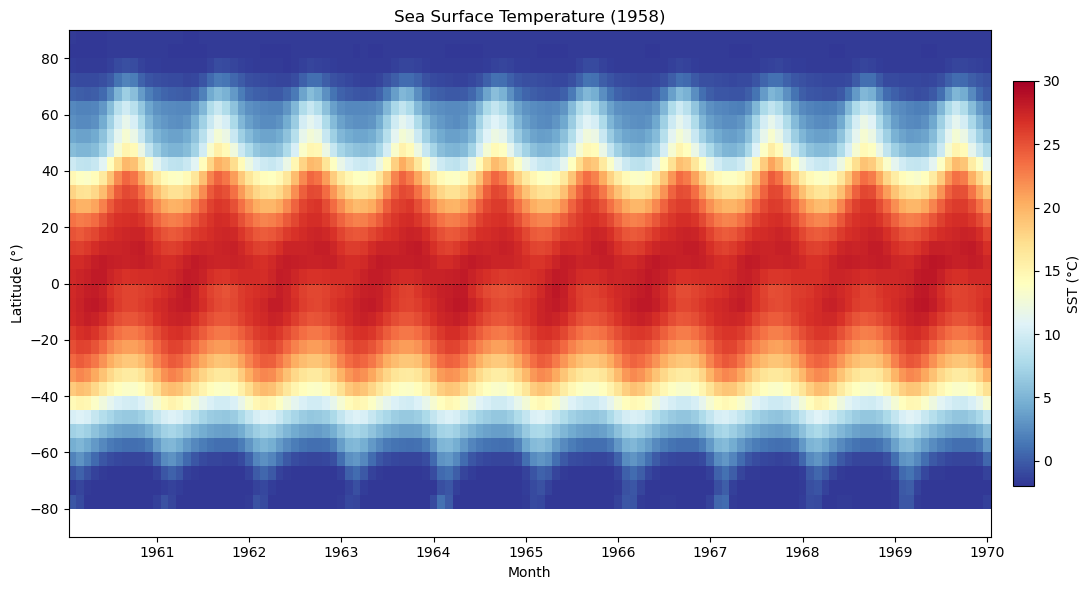

In [27]:
# Plot time-latitude Hovmoller for SST
fig, ax = nr.plot_hovmoller(
    t_out, lat_out, hov_lat,
    mode="latitude",
    cmap="RdYlBu_r",
    vmin=-2, vmax=30,
    colorbar_label="SST (°C)",
    title="Sea Surface Temperature (1960s)",
    figsize=(12, 6)
)

ax.set_xlabel("Month")
ax.axhline(0, color='k', linestyle='--', linewidth=0.5)  # Equator
plt.tight_layout()

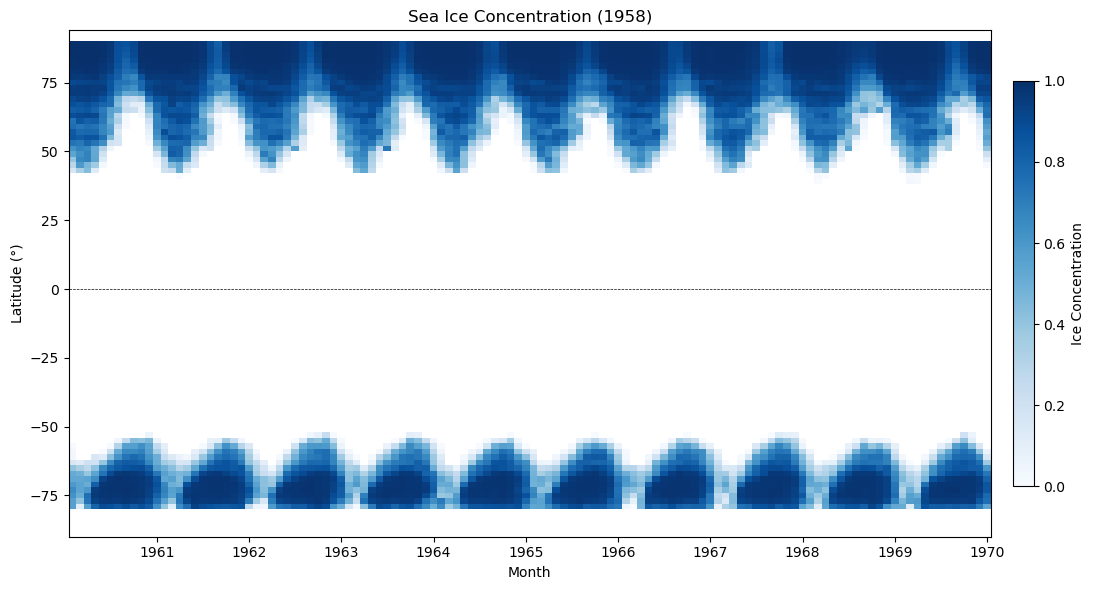

In [30]:
# Time-latitude Hovmoller for ice concentration
sic_all = data_conc['a_ice']  # Shape: (time, npoints)

t_out, lat_out, hov_ice = nr.hovmoller(
    sic_all, area[0],
    time=data.time,
    lat=lat,
    mode="latitude",
    lat_bins=np.arange(-90, 95, 2)  # Finer bins for ice
)

fig, ax = nr.plot_hovmoller(
    t_out, lat_out, hov_ice,
    mode="latitude",
    cmap="Blues",
    vmin=0, vmax=1,
    colorbar_label="Ice Concentration",
    title="Sea Ice Concentration (1958)",
    figsize=(12, 6)
)

ax.set_xlabel("Month")
ax.axhline(0, color='k', linestyle='--', linewidth=0.5)
plt.tight_layout()

### 3.3 Custom Multi-Panel Hovmoller

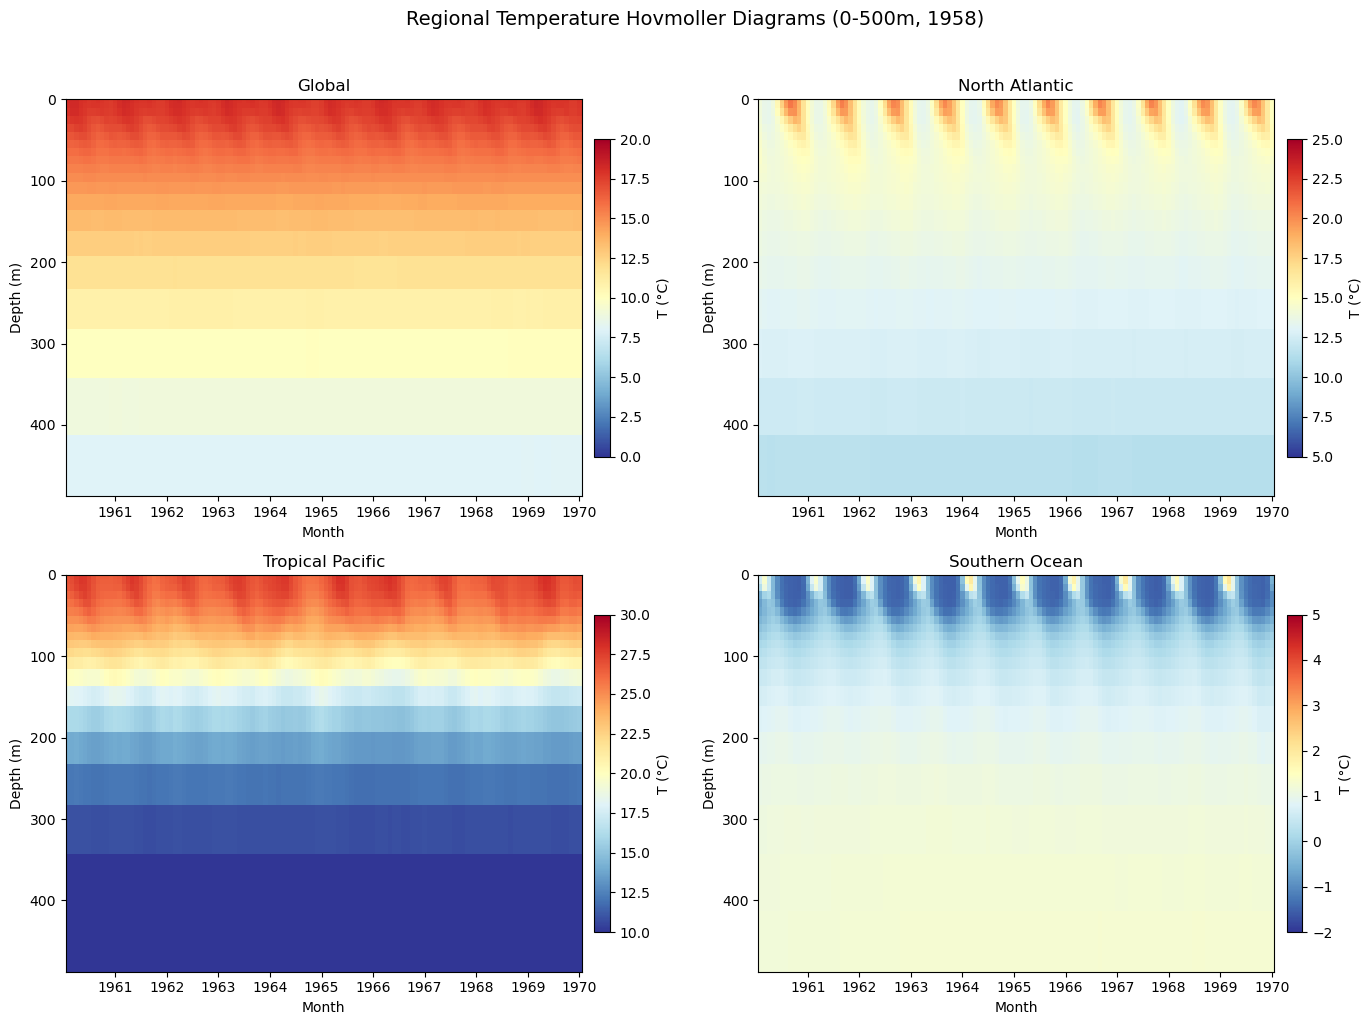

In [31]:
# Create multi-panel figure comparing different regions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Global time-depth
t_out, z_out, hov_global = nr.hovmoller(
    temp_upper, area_upper, time=data.time, depth=depth_upper, mode="depth"
)
nr.plot_hovmoller(t_out, z_out, hov_global, mode="depth", ax=axes[0, 0],
                  cmap="RdYlBu_r", vmin=0, vmax=20,
                  title="Global", colorbar_label="T (°C)")

# North Atlantic time-depth
natl_mask = (lat > 20) & (lat < 70) & (lon > -80) & (lon < 0)
_, _, hov_natl = nr.hovmoller(
    temp_upper, area_upper, time=data.time, depth=depth_upper, mode="depth", mask=natl_mask
)
nr.plot_hovmoller(t_out, z_out, hov_natl, mode="depth", ax=axes[0, 1],
                  cmap="RdYlBu_r", vmin=5, vmax=25,
                  title="North Atlantic", colorbar_label="T (°C)")

# Tropical Pacific time-depth
trop_pac_mask = (lat > -10) & (lat < 10) & ((lon > 120) | (lon < -80))
_, _, hov_tpac = nr.hovmoller(
    temp_upper, area_upper, time=data.time, depth=depth_upper, mode="depth", mask=trop_pac_mask
)
nr.plot_hovmoller(t_out, z_out, hov_tpac, mode="depth", ax=axes[1, 0],
                  cmap="RdYlBu_r", vmin=10, vmax=30,
                  title="Tropical Pacific", colorbar_label="T (°C)")

# Southern Ocean time-depth
so_mask = lat < -60
_, _, hov_so = nr.hovmoller(
    temp_upper, area_upper, time=data.time, depth=depth_upper, mode="depth", mask=so_mask
)
nr.plot_hovmoller(t_out, z_out, hov_so, mode="depth", ax=axes[1, 1],
                  cmap="RdYlBu_r", vmin=-2, vmax=5,
                  title="Southern Ocean", colorbar_label="T (°C)")

# Format x-axes
for ax in axes.flat:
    ax.set_xlabel("Month")

plt.suptitle("Regional Temperature Hovmoller Diagrams (0-500m, 1958)", fontsize=14, y=1.02)
plt.tight_layout()

---
## Summary

This notebook demonstrated the diagnostic functions in `nereus`:

### Sea Ice Diagnostics
- **`nr.ice_area(concentration, area, mask=None)`** - Total sea ice area (concentration-weighted)
- **`nr.ice_volume(thickness, area, concentration=None, mask=None)`** - Total sea ice volume
- **`nr.ice_extent(concentration, area, threshold=0.15, mask=None)`** - Sea ice extent

### Ocean Diagnostics
- **`nr.volume_mean(data, area, thickness, depth, depth_min, depth_max, mask)`** - Volume-weighted mean
- **`nr.heat_content(temp, area, thickness, depth, depth_min, depth_max, reference_temp, mask)`** - Ocean heat content

### Hovmoller Diagrams
- **`nr.hovmoller(data, area, time, depth/lat, mode)`** - Compute Hovmoller data
- **`nr.plot_hovmoller(time, y, data, mode)`** - Plot Hovmoller diagrams

### Key Features
- All functions support arbitrary masks for regional analysis
- Ocean diagnostics support depth range selection
- Works with both numpy arrays and xarray DataArrays
- Handles NaN values gracefully